# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

In [54]:
# Import Library untuk mengolah data
import pandas as pd
import numpy as np

#Import Library untuk visualisasi data
import seaborn as sns, matplotlib.pyplot as plt

#Import Library untuk statistika model
from statsmodels.tsa.seasonal import seasonal_decompose 

#Import Library untuk Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [55]:
#Load dataset
data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv', 
                   index_col=[0], parse_dates=[0]
)

In [56]:
# Mendapatkan informasi data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<div class="alert-info">
    

<b>Note</b>

<b>num_orders</b> — Jumlah Order <br>


## Persiapan

In [57]:
# Getting sum data order for every 1 hour
data = data.resample('1H').sum()

In [58]:
# Melakukan pengecekan data
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analisis

In [59]:
# Mendapatkan informasi detil data
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [60]:
# Getting sum data for every 1 day and month
data_month_sum = data.resample('1M').sum()
data_day_sum = data.resample('1D').sum()

<AxesSubplot:xlabel='datetime'>

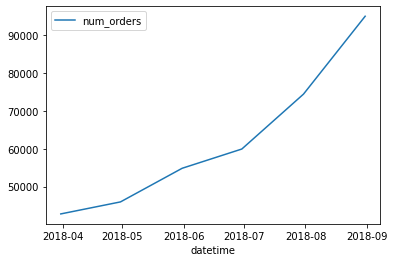

In [61]:
# Melihat persebaran data order setiap bulannya.
sns.lineplot(data=data_month_sum)

<AxesSubplot:xlabel='datetime'>

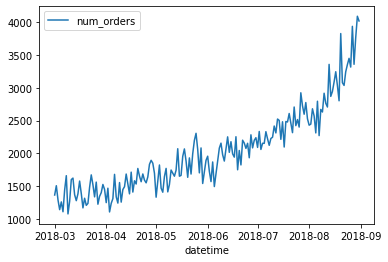

In [62]:
# Melihat persebaran data order setiap harinya
sns.lineplot(data=data_day_sum)

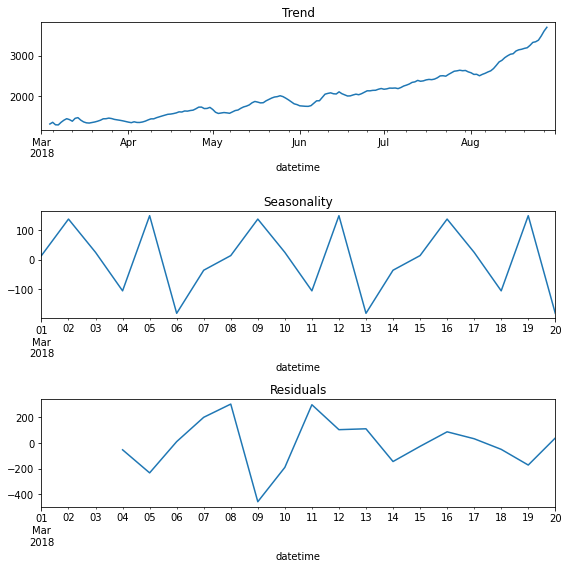

In [63]:
# Melihat trend , Seasonal dan residual data
decomposed = seasonal_decompose(data_day_sum)
plt.figure(figsize=(8, 8)) 

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca()) 
plt.title('Trend') 

plt.subplot(312) 
decomposed.seasonal['2018-03-01':'2018-03-20'].plot(ax=plt.gca()) 
plt.title('Seasonality') 
plt.subplot(313) 
decomposed.resid['2018-03-01':'2018-03-20'].plot(ax=plt.gca()) 
plt.title('Residuals') 

plt.tight_layout()

In [64]:
# Melihat data dayofweek
data_day_sum['day_of_week'] = data_day_sum.index.dayofweek
data_day_sum['day_of_week'].head(15)


datetime
2018-03-01    3
2018-03-02    4
2018-03-03    5
2018-03-04    6
2018-03-05    0
2018-03-06    1
2018-03-07    2
2018-03-08    3
2018-03-09    4
2018-03-10    5
2018-03-11    6
2018-03-12    0
2018-03-13    1
2018-03-14    2
2018-03-15    3
Freq: D, Name: day_of_week, dtype: int64

<div class="alert-info">
    

<b>Insight</b>

- Trend penjualan meningkat setiap bulannya.
- Order terendah terdapat disetiap hari selasa.

## Pelatihan

In [65]:
# Membuat fungsi kalender, lag dan moving average
def make_features(df, max_lag, rolling_mean_size):
    data['year'] = df.index.year
    data['month'] = df.index.month
    data['day'] = df.index.day
    data['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

In [66]:
# Mengaplikasikan fitur pada data
make_features(df=data, max_lag=24, rolling_mean_size=10)

In [67]:
# Train test split
train, test = train_test_split(data, shuffle=False, test_size=0.1)


In [68]:
# menghapus data training dengan nilai kosong/ NaN
train = train.dropna()

In [69]:
# Membagi fitur dan target pada data Train dan test
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Linear Regression

In [70]:
# Menetapkan model
lr = LinearRegression()

In [71]:
# Melatih data menggunakan model Linear Regression
lr.fit(features_train, target_train)

LinearRegression()

In [72]:
# Memprediksi data menggunakan model Linear Regression
y_pred_lr = lr.predict(features_test)

In [73]:
# kalkulasi nilai RMSE
rmse = np.sqrt(mean_squared_error(target_test, y_pred_lr))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 45.529337080209395


### Ridge Regression

In [92]:
# Menetapkan model
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)

In [93]:
# Melatih data menggunakan model Linear Regression
ridge.fit(features_train, target_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [94]:
# Memprediksi data menggunakan model Linear Regression
y_pred_ridge = ridge.predict(features_test)

In [95]:
# kalkulasi nilai RMSE
rmse = np.sqrt(mean_squared_error(target_test, y_pred_ridge))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 45.523811284860656


### Lasso Regression

In [99]:
# Menetapkan model
lasso = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)

In [100]:
# Melatih data menggunakan model Linear Regression
lasso.fit(features_train, target_train)

LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)

In [101]:
# Memprediksi data menggunakan model Linear Regression
y_pred_lasso = lasso.predict(features_test)

In [102]:
# kalkulasi nilai RMSE
rmse = np.sqrt(mean_squared_error(target_test, y_pred_lasso))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 45.47600252748553


### Random Forest Regression

In [278]:
# Menetapkan model
rf = RandomForestRegressor(n_estimators=50,random_state=12, max_depth=18)

In [279]:
# Melatih data menggunakan model Linear Regression
rf.fit(features_train, target_train)

RandomForestRegressor(max_depth=18, n_estimators=50, random_state=12)

In [280]:
# Memprediksi data menggunakan model Linear Regression
y_pred_rf = rf.predict(features_test)

In [281]:
# kalkulasi nilai RMSE
rmse = np.sqrt(mean_squared_error(target_test, y_pred_rf))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 42.315224849775895


### Gradient Boosting

In [234]:
# Menetapkan model
gbr = GradientBoostingRegressor(n_estimators=100, random_state=12, max_depth=9)

In [235]:
# Melatih data menggunakan model Linear Regression
gbr.fit(features_train, target_train)

GradientBoostingRegressor(max_depth=9, random_state=12)

In [236]:
# Memprediksi data menggunakan model Linear Regression
y_pred_gbr = gbr.predict(features_test)

In [237]:
# kalkulasi nilai RMSE
rmse = np.sqrt(mean_squared_error(target_test, y_pred_gbr))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 44.037926865883726


## Pengujian

In [50]:
# Menetapkan Model yang digunakan.
models = [
('Linear Regression', LinearRegression()),
('Ridge Regression', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)),
('Lasso Regression', LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)),
('Random Forest', RandomForestRegressor(n_estimators=20,random_state=12, max_depth=18)),
('Gradient Boosting', GradientBoostingRegressor(n_estimators=20, random_state=12))]

evaluation_metrics = {'Model': [], 'RMSE': []}

In [51]:
# Looping model dan penilaian.
for name, model in models:
    model.fit(features_train, target_train)
    y_pred = model.predict(features_test)
    RMSE = np.sqrt(mean_squared_error(target_test, y_pred))
   
    evaluation_metrics['Model'].append(name)
    evaluation_metrics['RMSE'].append(RMSE)

In [53]:
# Membuat table evaluasi
evaluation_metrics_df = pd.DataFrame(evaluation_metrics)
print(evaluation_metrics_df)

               Model       RMSE
0  Linear Regression  40.540767
1   Ridge Regression  40.536892
2   Lasso Regression  40.505405
3      Random Forest  42.523442
4  Gradient Boosting  52.763006


<div class="alert-info">
    

<b>Insight</b>

RMSE tidak lebih dari 48 pada model Linear Regression, Ridge Regression, Lasso Regression dan Random Forest.